In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk
from collections import defaultdict
import re

from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure

from IPython.display import display, HTML

from functools import reduce

import warnings
warnings.simplefilter('ignore')

/home/snath/miniconda3/envs/process_modelling/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Functions

In [2]:
def get_clusters(embeddings, texts, cluster_assignment, printclusters):
    """Helper function for perform_hierarchicalClustering()
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        cluster_assignment (list): cluster assignment for each text/embedding
        printcluster (bool): True will print all texts in each cluster
    Returns:
        response_to_cluster dict: text to cluster number
        cluster_to_response dict: cluster number to list of texts in that cluster
        num_clusters int: number of clusters
        min_similarities dict: cluster to min text similiarity
    """

    cluster_to_response = defaultdict(list)                                 # make cluster_to_response
    cluster_to_embeddings = defaultdict(list)                               # make cluster_to_embeddings (used for min sim)
    for ind, cluster_num in enumerate(cluster_assignment):
        cluster_to_response[cluster_num].append(texts[ind])
        cluster_to_embeddings[cluster_num].append(embeddings[ind])
    
    response_to_cluster = dict(zip(texts, cluster_assignment))              # make response_to_cluster 
    
    num_clusters = len(np.unique(cluster_assignment))                       # find num clusters

    min_similarities = {}   
    mean_similarities = {}                                                   # find min paiwise text similarity in each cluster
    for cl in cluster_to_embeddings:
        stacked = np.array(cluster_to_embeddings[cl])
        sim = stacked @ stacked.T
        mean_sim = np.mean(sim)
        mean_similarities[cl] = mean_sim
        np.fill_diagonal(sim, np.inf)
        min_sim = np.min(sim)
        min_similarities[cl] = min_sim

    # code to get interpretation of each cluster 
    
    if printclusters:                                                       # print clusters if True
        for cluster_num, responses in cluster_to_response.items():
            print(f"Cluster {cluster_num}")
            print(responses, end="\n\n")
    
    cluster_sizes = [len(cluster_to_response[key]) for key in cluster_to_response]
    
    # fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    # ax[0].hist(cluster_sizes, color="lightseagreen")
    # ax[0].set_xlabel("Cluster Size")
    # ax[0].set_xlim(0, 600)
    # ax[0].set_ylabel("Frequency")
    # similarity_values = list(mean_similarities.values())
    # min_sim = min(similarity_values)
    # max_sim = max(similarity_values)
    # normalized_similarities = [(sim - min_sim) / (max_sim - min_sim) for sim in similarity_values]
    # ax[1].hist(normalized_similarities, color="lightseagreen")
    # ax[1].set_xlabel("Cluster Mean Pairwise Similarity")
    # ax[1].set_xlim(0, 1)
    # ax[1].set_ylabel("Frequency")
    # plt.show()

    return response_to_cluster, cluster_to_response, num_clusters, min_similarities, mean_similarities

def perform_hierarchicalClustering(embeddings, texts, method, printclusters, ax=None):
    """Performs hierarchical clustering
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        ax: axes for plotting
        method (tuple): a: distance/maxclust based clustering, b: distance threshold/max number of clusters
        printcluster (bool): True will print all texts in each cluster
    Calls:
        get_clusters()
    """
    linked = linkage(embeddings, 'ward')                                                                                                    # 'ward' distance for measuring distance between clusters
    
    if ax is not None:
        # Elbow plot -- Plot mean minsim/number of clusters as a fn of cut-off distance
        mean_minsemsim = []
        num_clusters = []
        for cod in np.linspace(1, 8, 30):
            cluster_assignment = fcluster(linked, t=cod, criterion='distance')
            _, _, _, minsims, _ = get_clusters(embeddings, texts, cluster_assignment, False)
            mean_minsemsim.append(np.mean(list(minsims.values())))
            num_clusters.append(len(np.unique(cluster_assignment)))
    
        dendrogram(linked, orientation='top', labels=texts, distance_sort='descending', show_leaf_counts=False, no_labels=True, ax=ax[0])       # Make dendogram
        ax[1].plot(np.linspace(1, 8, 30), mean_minsemsim)
        ax[1].set_xlabel("Cut-off distance"); ax[1].set_ylabel("Mean cluster semantic similarity")
        ax[2].plot(np.linspace(1, 8, 30), num_clusters)
        ax[2].set_xlabel("Cut-off distance"); ax[2].set_ylabel("Number of clusters")

    cluster_assignment = fcluster(linked, t=method[1], criterion=method[0])         # assign clusters
    return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def write_category_jump(data, context, embeddings, response_to_cluster):
    data[f"category_stella_{context}"] = data["response"].apply(lambda x: response_to_cluster.get(x))
    data[f"jump_cat_stella_{context}"] = (~(data[f"category_stella_{context}"].diff() == 0)).astype(int)
    return data

def cleaned(context):
    context = context.replace("(", "")
    context = context.replace(")", "")
    context = context.replace("_", "")
    context = context.replace("/", "")
    return context

def get_cluster_agreement(cluster_assignment1, cluster_assignment2):
    ari = adjusted_rand_score(cluster_assignment1, cluster_assignment2)
    nmi = normalized_mutual_info_score(cluster_assignment1, cluster_assignment2)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(cluster_assignment1, cluster_assignment2)
    return f"{np.round(ari, 1)}, {np.round(nmi, 1)}, {np.round(homogeneity, 1)}, {np.round(completeness, 1)}, {np.round(v_measure, 1)}"

def display_agreement_matrix(agreement_matrix, contexts):
    df = pd.DataFrame(agreement_matrix, index=contexts, columns=contexts)
    html = df.to_html(classes="table table-striped table-bordered", index=True)

    # Add CSS for freezing the header and the first column
    style = """
        <style>
            .dataframe tbody tr th { position: sticky; left: 0; background-color: #000000; z-index: 1; }
            .dataframe thead th { position: sticky; top: 0; background-color: #000000; z-index: 2; }
            .dataframe { width: 100%; height: 400px; overflow: auto; display: block; }
        </style>
    """

    # Display the styled DataFrame with frozen header and first column
    display(HTML(style + html))

In [3]:
data = pd.read_csv("../csvs/data_humans_allresponses.csv")
texts_autbrick = data[data["task"] == 2]["response"].unique().tolist()
texts_autpaperclip = data[data["task"] == 3]["response"].unique().tolist()
texts_vf = data[data["task"] == 1]["response"].unique().tolist()

wikipedia_contexts = pk.load(open("../pickle/wikipedia_contexts.pk", "rb"))

In [4]:
data_autbrick = data[data["task"] == 2].reset_index(drop=True)
data_autpaperclip = data[data["task"] == 3].reset_index(drop=True)
data_vf = data[data["task"] == 1].reset_index(drop=True)

In [5]:
printclusters = False

nocontext


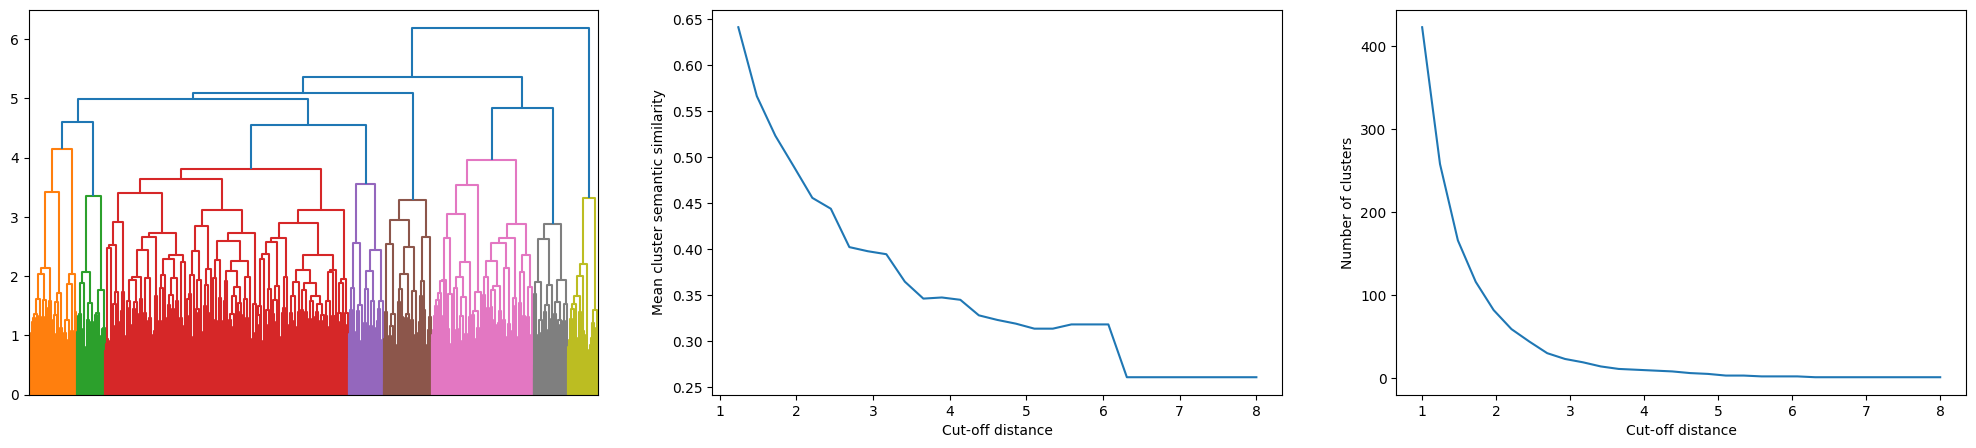

brick


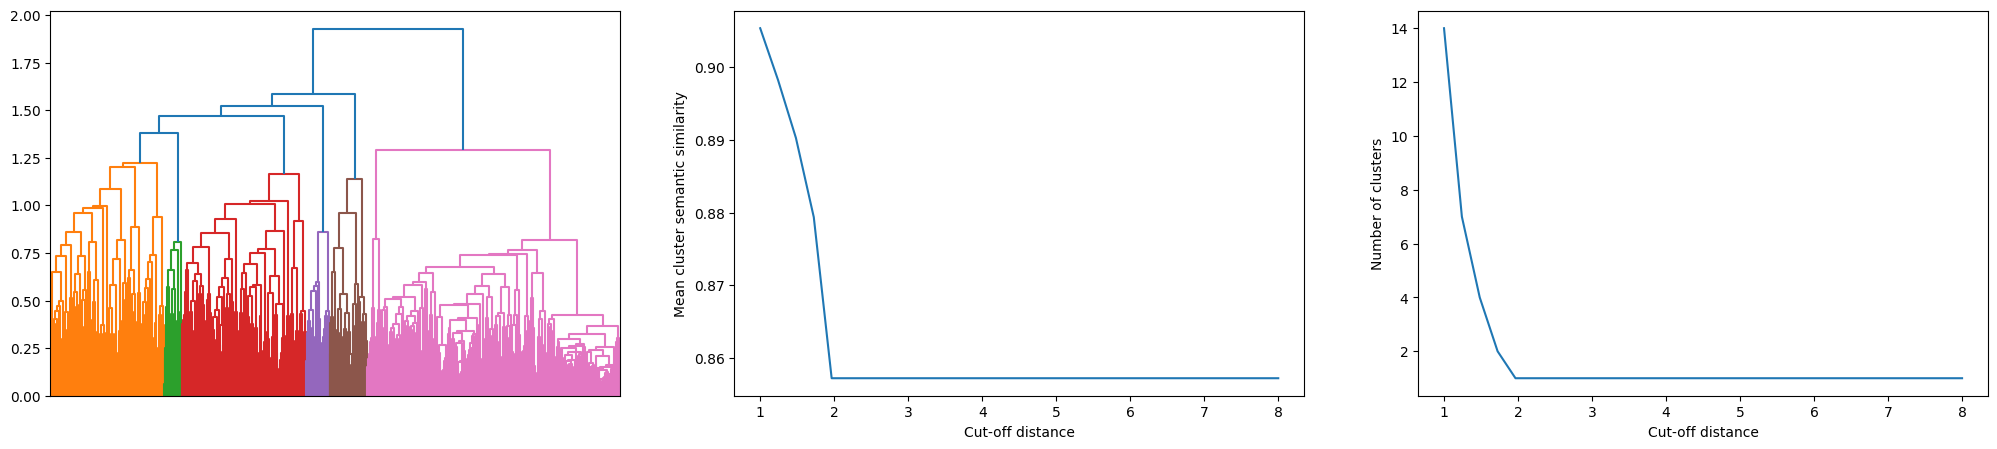

Masonry


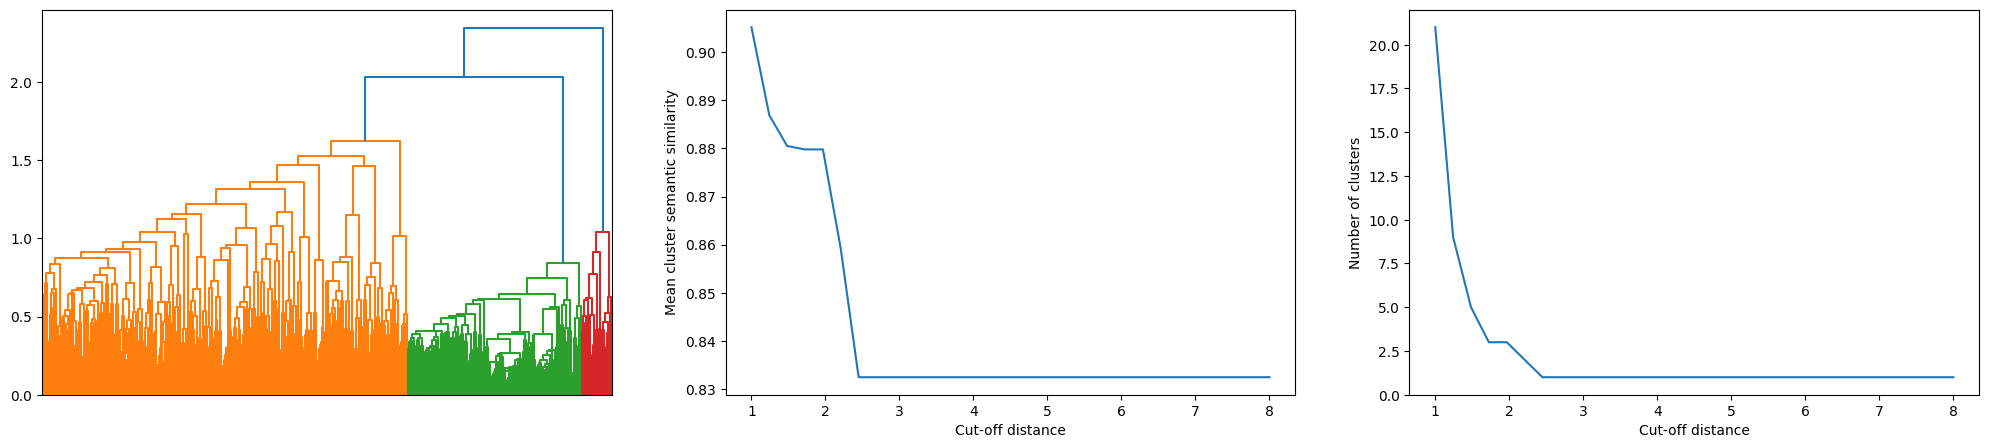

Clay


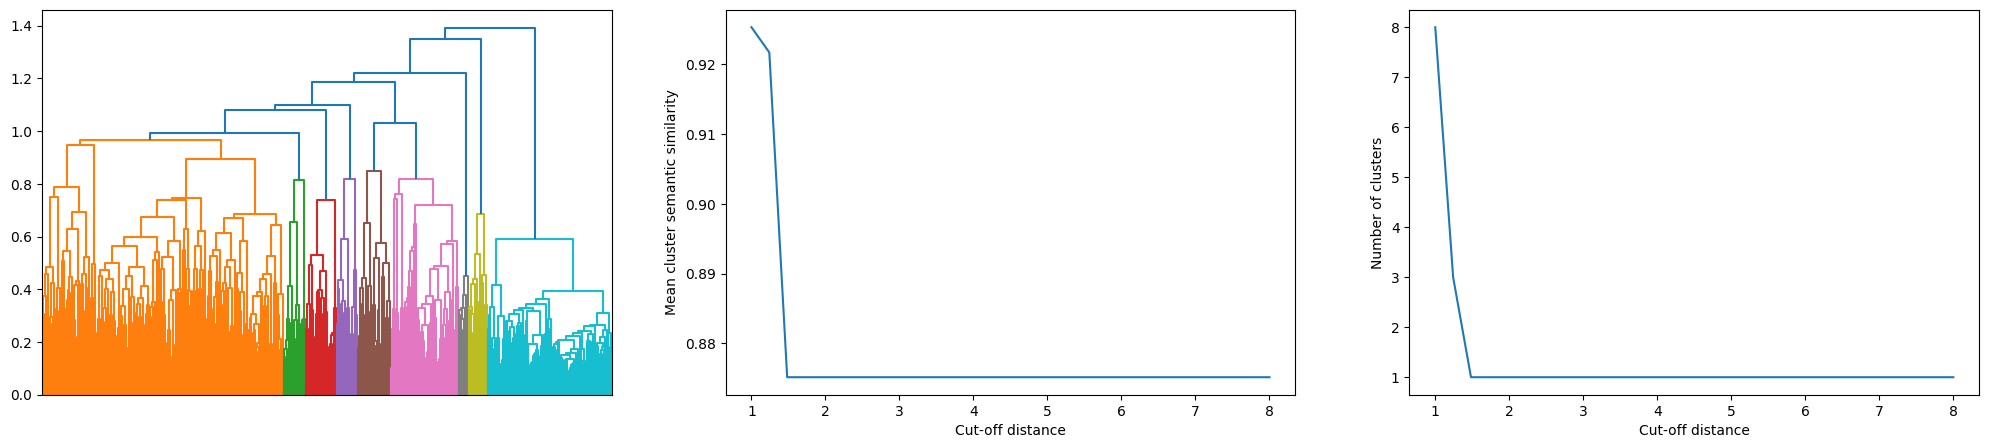

Mortarmasonry


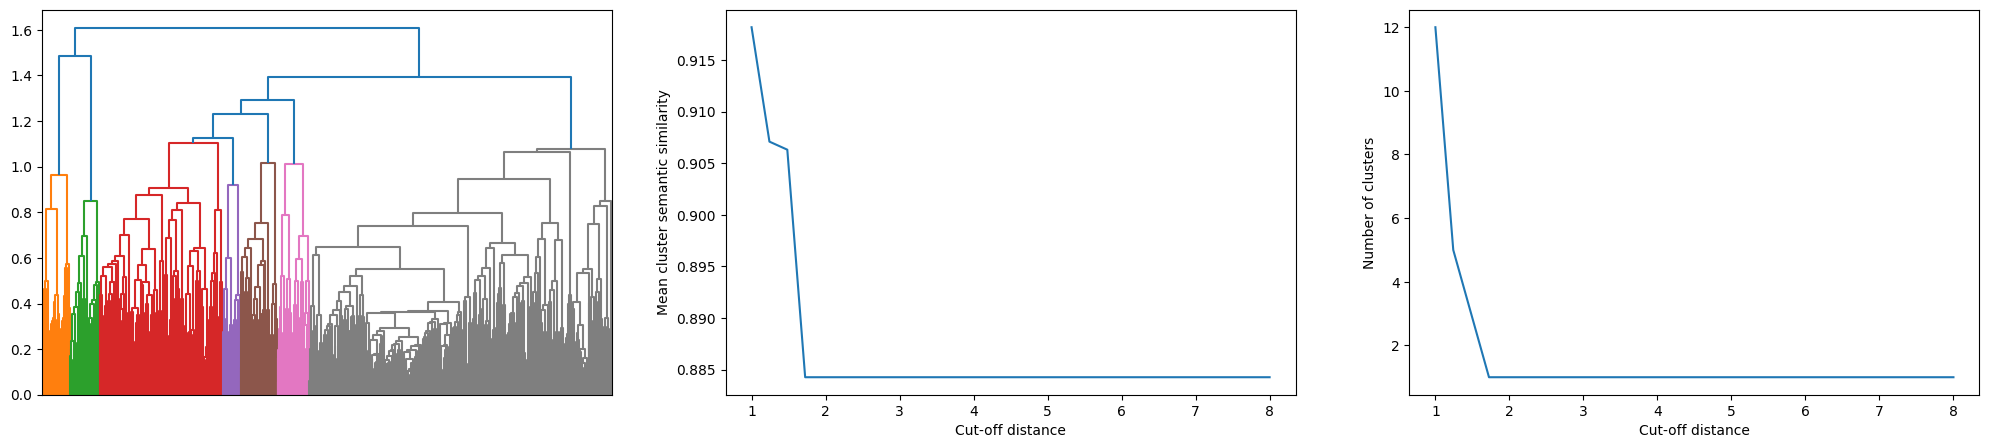

Brickworks


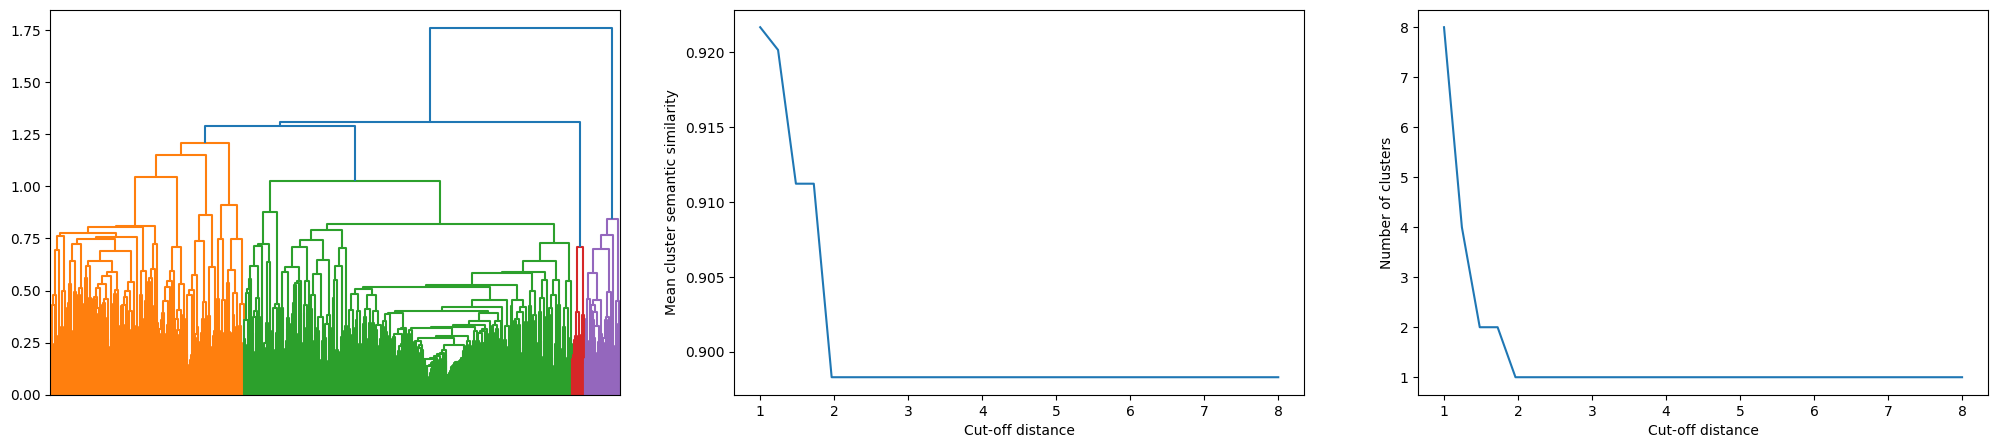

Concretemasonryunit


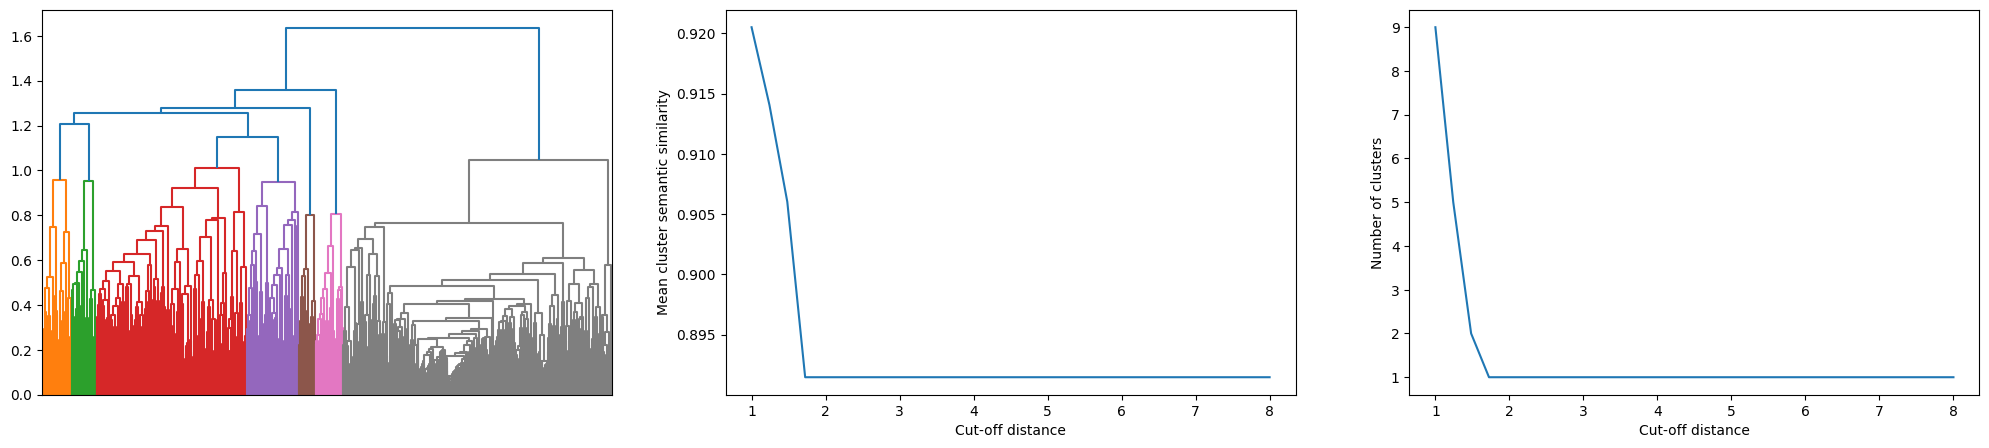

Expandedclayaggregate


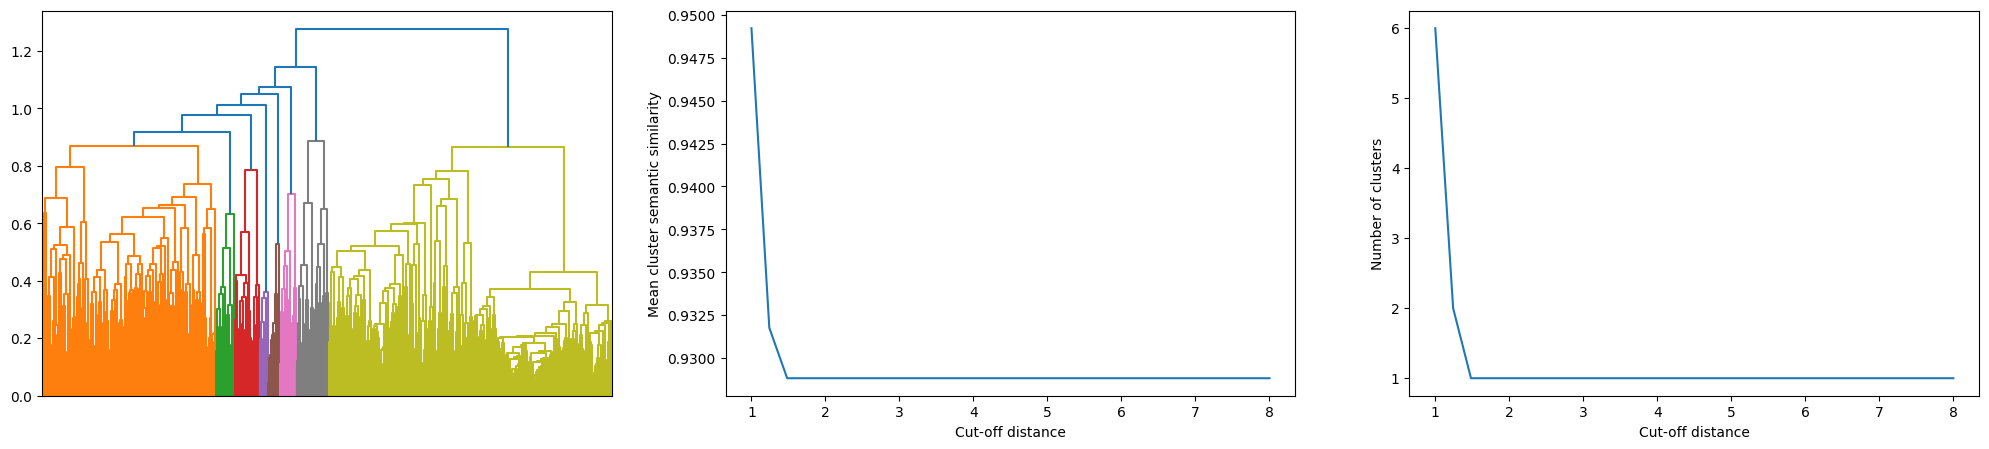

Buildingmaterial


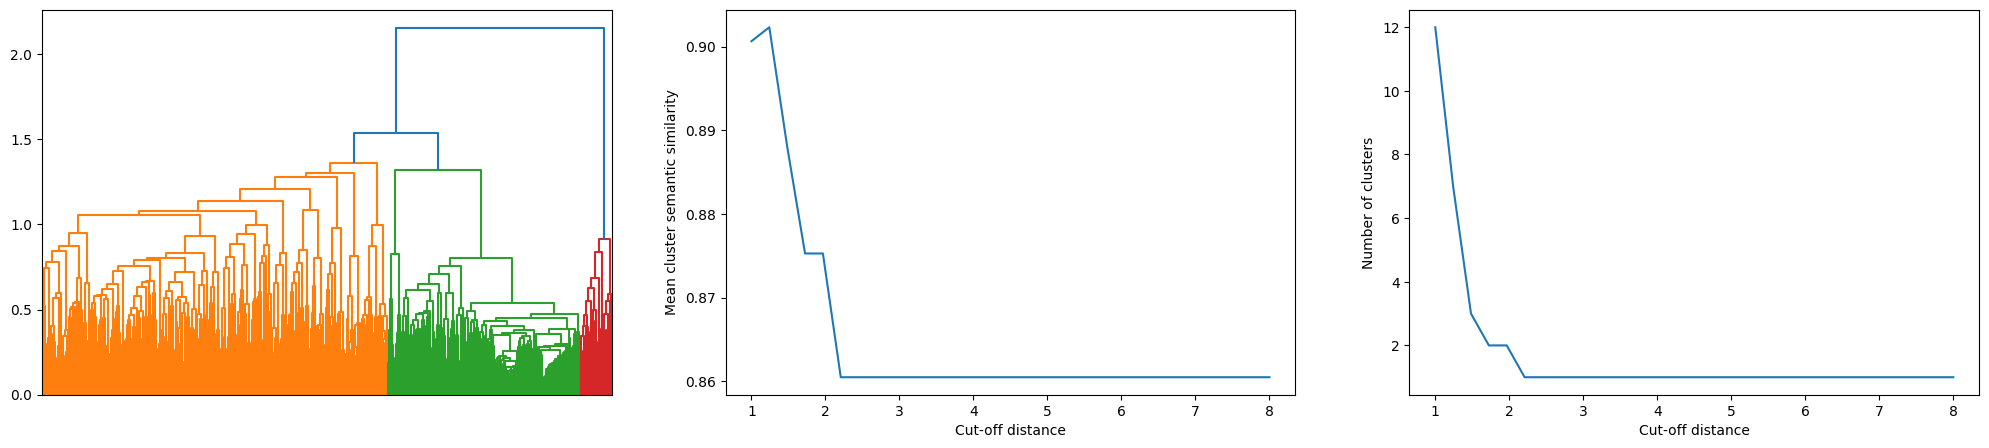

Mudbrick


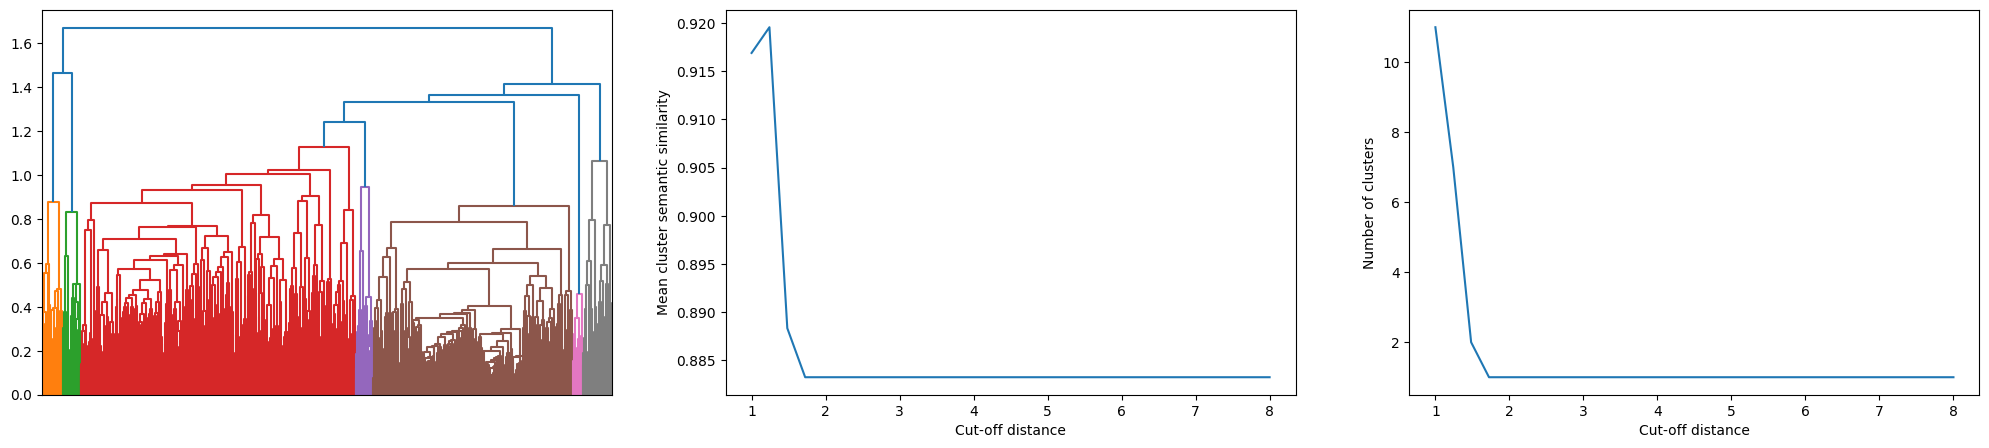

Brickwork


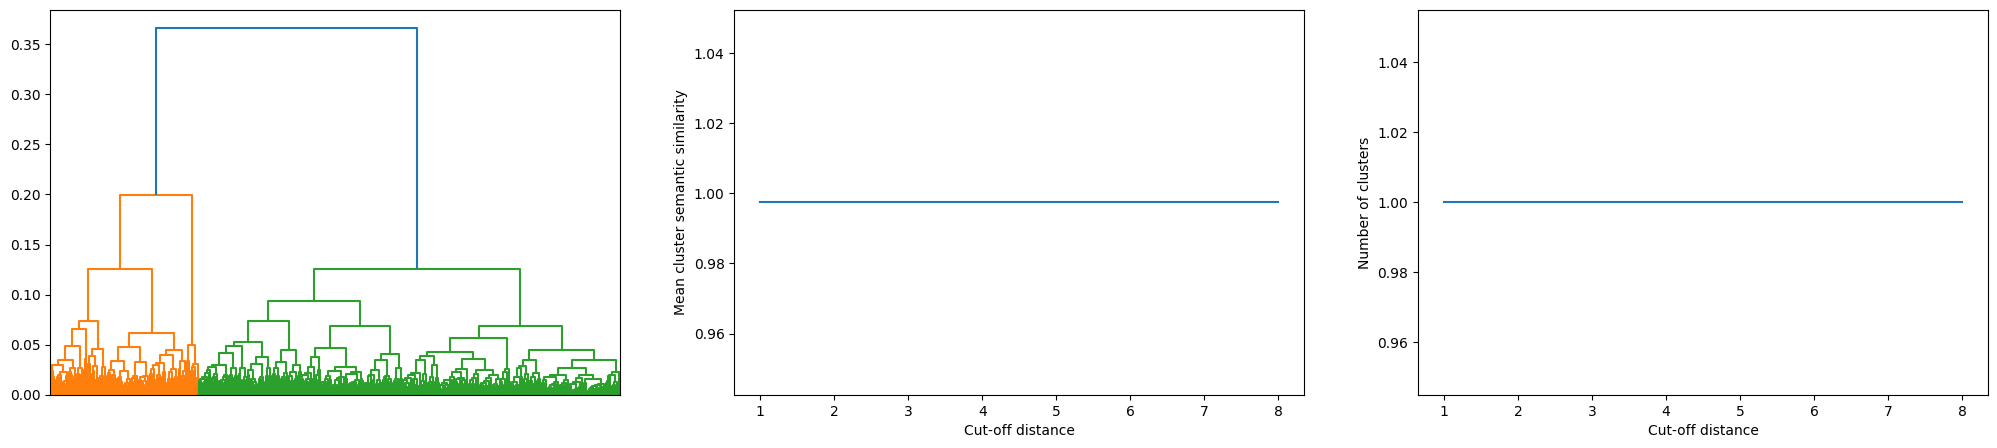

In [6]:
clustering_info = {}
for i, context in enumerate(wikipedia_contexts["autbrick"]):
    context = cleaned(context)
    print(context)

    embeddings = pk.load(open(f"../embeddings/embeddings_stella_autbrick_{context}.pk", "rb"))

    fig, ax = plt.subplots(1, 3, figsize=(25, 5))
    response_to_cluster, cluster_to_response, num_clusters, minsim, meansim = perform_hierarchicalClustering([embeddings[x] for x in texts_autbrick], texts_autbrick, ("maxclust", 25), printclusters, ax)
    # print("Num clusters =", num_clusters)
    # print(np.min(list(minsim.values())), np.mean(list(minsim.values())))

    clustering_info[f"autbrick_stella_{context}"] = {"response_to_cluster": response_to_cluster, "cluster_to_response": cluster_to_response}
    data_autbrick = write_category_jump(data_autbrick, context, embeddings, response_to_cluster)
    plt.show()

In [7]:
total_combinations = len(wikipedia_contexts["autbrick"])
agreement_matrix = np.empty((total_combinations, total_combinations), dtype=object)

for i in range(total_combinations):
    for j in range(0, i + 1):
        context1 = cleaned(list(wikipedia_contexts["autbrick"].keys())[i])
        context2 = cleaned(list(wikipedia_contexts["autbrick"].keys())[j])
        try:
            cluster1 = data_autbrick[f"category_stella_{context1}"].values
            cluster2 = data_autbrick[f"category_stella_{context2}"].values
            agreement_matrix[i, j] = get_cluster_agreement(cluster1, cluster2)
        except:
            agreement_matrix[i, j] = "NA"

In [8]:
display_agreement_matrix(agreement_matrix, [cleaned(c) for c in list(wikipedia_contexts["autbrick"].keys())])

,nocontext,brick,Masonry,Clay,Mortarmasonry,Brickworks,Concretemasonryunit,Expandedclayaggregate,Buildingmaterial,Mudbrick,Brickwork
nocontext,"1.0, 1.0, 1.0, 1.0, 1.0",None,None,None,None,None,None,None,None,None,None
brick,"0.1, 0.5, 0.6, 0.4, 0.5","1.0, 1.0, 1.0, 1.0, 1.0",None,None,None,None,None,None,None,None,None
Masonry,"0.2, 0.6, 0.6, 0.5, 0.6","0.5, 0.7, 0.6, 0.7, 0.7","1.0, 1.0, 1.0, 1.0, 1.0",None,None,None,None,None,None,None,None
Clay,"0.2, 0.5, 0.5, 0.5, 0.5","0.2, 0.6, 0.5, 0.6, 0.6","0.3, 0.6, 0.5, 0.6, 0.6","1.0, 1.0, 1.0, 1.0, 1.0",None,None,None,None,None,None,None
Mortarmasonry,"0.2, 0.5, 0.6, 0.5, 0.5","0.5, 0.7, 0.6, 0.7, 0.7","0.4, 0.6, 0.6, 0.7, 0.6","0.3, 0.6, 0.6, 0.6, 0.6","1.0, 1.0, 1.0, 1.0, 1.0",None,None,None,None,None,None
Brickworks,"0.2, 0.5, 0.6, 0.5, 0.5","0.5, 0.6, 0.6, 0.6, 0.6","0.5, 0.7, 0.7, 0.6, 0.7","0.3, 0.6, 0.6, 0.6, 0.6","0.4, 0.6, 0.7, 0.6, 0.6","1.0, 1.0, 1.0, 1.0, 1.0",None,None,None,None,None
Concretemasonryunit,"0.1, 0.5, 0.6, 0.4, 0.5","0.6, 0.7, 0.6, 0.7, 0.7","0.5, 0.6, 0.7, 0.6, 0.6","0.3, 0.6, 0.6, 0.5, 0.6","0.4, 0.6, 0.7, 0.6, 0.6","0.5, 0.6, 0.6, 0.6, 0.6","1.0, 1.0, 1.0, 1.0, 1.0",None,None,None,None
Expandedclayaggregate,"0.2, 0.5, 0.6, 0.5, 0.5","0.3, 0.6, 0.5, 0.6, 0.6","0.3, 0.6, 0.6, 0.6, 0.6","0.3, 0.6, 0.6, 0.6, 0.6","0.3, 0.6, 0.6, 0.6, 0.6","0.3, 0.6, 0.6, 0.6, 0.6","0.4, 0.6, 0.6, 0.7, 0.6","1.0, 1.0, 1.0, 1.0, 1.0",None,None,None
Buildingmaterial,"0.2, 0.5, 0.6, 0.5, 0.5","0.4, 0.6, 0.6, 0.6, 0.6","0.5, 0.6, 0.6, 0.6, 0.6","0.2, 0.5, 0.6, 0.5, 0.5","0.4, 0.6, 0.6, 0.6, 0.6","0.5, 0.7, 0.6, 0.7, 0.7","0.4, 0.6, 0.6, 0.6, 0.6","0.3, 0.6, 0.6, 0.5, 0.6","1.0, 1.0, 1.0, 1.0, 1.0",None,None
Mudbrick,"0.2, 0.5, 0.6, 0.5, 0.5","0.4, 0.6, 0.6, 0.7, 0.6","0.4, 0.6, 0.6, 0.6, 0.6","0.2, 0.6, 0.6, 0.5, 0.6","0.4, 0.7, 0.7, 0.6, 0.7","0.5, 0.7, 0.7, 0.7, 0.7","0.4, 0.6, 0.6, 0.7, 0.6","0.4, 0.7, 0.7, 0.7, 0.7","0.4, 0.6, 0.6, 0.6, 0.6","1.0, 1.0, 1.0, 1.0, 1.0",None


In [9]:
data_autbrick["jump"] = reduce(lambda x, y: x & y, [data_autbrick[x] for x in data_autbrick.columns if "jump_cat" in x])
data_autbrick["jump_profile"] = data_autbrick.groupby("pid")["jump"].cumsum()

In [10]:
data_autbrick_clustering = data_autbrick.groupby("pid").filter(lambda x: len(x) >= 18)      # only consider responses with atleast num_resp responses
data_autbrick_clustering = data_autbrick_clustering[data_autbrick_clustering["order"] <= 18]

In [11]:
data_autbrick_clustering

,pid,task,starttime,endtime,original_response_Dutch,original_response,original_response_cleaned,response,invalid,jump_GT,...,category_stella_Expandedclayaggregate,jump_cat_stella_Expandedclayaggregate,category_stella_Buildingmaterial,jump_cat_stella_Buildingmaterial,category_stella_Mudbrick,jump_cat_stella_Mudbrick,category_stella_Brickwork,jump_cat_stella_Brickwork,jump,jump_profile
0,2657,2,1612269779414,1612269786513,huis,house,house,house,0.0,1.0,...,7,1,3,1,6,1,5,1,1,1
1,2657,2,1612269786513,1612269794487,brug,bridge,bridge,bridge,0.0,1.0,...,7,0,3,0,19,1,4,1,0,1
2,2657,2,1612269794487,1612269797025,school,school,school,school,0.0,1.0,...,7,0,21,1,19,0,2,1,0,1
3,2657,2,1612269797025,1612269799090,ministerie,ministry,ministry,ministry,0.0,0,...,1,1,3,1,6,1,2,0,0,1
4,2657,2,1612269799090,1612269803729,hotel,hotel,hotel,hotel,0.0,0,...,7,1,3,0,19,1,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,2970,2,1615381354405,1615381357745,jeu de boules,bocce,bocce,ball game,0.0,0,...,12,1,7,1,25,1,12,1,0,6
4151,2970,2,1615381357745,1615381369007,als kegels gebruiken bij bowlen,use as pins in bowling,pins bowling,bowling pins,0.0,0,...,12,0,7,0,25,0,14,1,0,6
4152,2970,2,1615381369007,1615381384280,stoel,chair,chair,chair,0.0,1.0,...,10,1,11,1,1,1,2,1,1,7
4153,2970,2,1615381384280,1615381387323,krukje,stool,stool,stool,0.0,1.0,...,8,1,12,1,3,1,1,1,0,7


In [12]:
data_autbrick_clustering.groupby("pid").agg(list)["jump_profile"].to_dict()

{2657: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
 2667: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 2668: [1, 2, 2, 2, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7],
 2672: [1, 2, 3, 4, 5, 6, 6, 7, 8, 8, 8, 9, 10, 10, 10, 11, 12, 12, 12],
 2673: [1, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5],
 2675: [1, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 2676: [0, 0, 1, 1, 2, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, 8, 8, 9],
 2677: [1, 2, 3, 4, 5, 5, 5, 5, 5, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14],
 2679: [1, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9, 9, 9, 9, 10, 10, 10, 11],
 2681: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3],
 2685: [0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4, 5, 6, 7, 7, 7],
 2687: [0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 5, 5, 5, 5, 6, 7, 8, 9, 10],
 2689: [0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4],
 2690: [1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 8],
 2693: [1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 4, 4, 4, 5, 6, 6, 

{2657: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], 2667: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 2668: [1, 2, 2, 2, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7], 2672: [1, 2, 3, 4, 5, 6, 6, 7, 8, 8, 8, 9, 10, 10, 10, 11, 12, 12, 12], 2673: [1, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5], 2675: [1, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 2676: [0, 0, 1, 1, 2, 2, 2, 3, 4, 5, 6, 6, 6, 6, 7, 7, 8, 8, 9], 2677: [1, 2, 3, 4, 5, 5, 5, 5, 5, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14], 2679: [1, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9, 9, 9, 9, 10, 10, 10, 11], 2681: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3], 2685: [0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4, 5, 6, 7, 7, 7], 2687: [0, 0, 0, 1, 2, 2, 3, 4, 5, 5, 5, 5, 5, 5, 6, 7, 8, 9, 10], 2689: [0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4], 2690: [1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 8], 2693: [1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 4, 4, 4, 5, 6, 6, 7], 2695: [1, 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (107,) + inhomogeneous part.

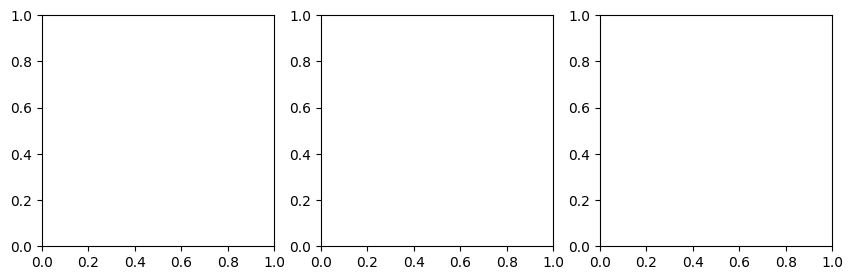

In [15]:
def perform_KMeans(embeddings, num_clusters):
    """Perform KMeans
    Args:
        embeddings (list): List of embeddings
        num_clusters: Number of clusters
    Returns:
        KMeans object
    """
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0)
    kmeans.fit(embeddings)
    return kmeans

def participant_clustering_cumjumps(data, num_resp):       # Cluster human data, assign LLM data
    num_clusters = 3
    _, ax = plt.subplots(1, num_clusters, figsize=(10.2, 3))

    pid_to_cumulative_jumps_profile = data.groupby("pid").agg(list)["jump_profile"].to_dict()
    print(pid_to_cumulative_jumps_profile)
    data_to_cluster = np.array(list(pid_to_cumulative_jumps_profile.values()))
    
    kmeans = perform_KMeans(data_to_cluster, num_clusters)
    labels = kmeans.labels_

    # For visualisation purposes:
    cl1meanjumps = sum(data_to_cluster[labels == 0, -1])/len(data_to_cluster[labels == 0, -1])
    cl2meanjumps = sum(data_to_cluster[labels == 1, -1])/len(data_to_cluster[labels == 1, -1])
    cl3meanjumps = sum(data_to_cluster[labels == 2, -1])/len(data_to_cluster[labels == 2, -1])
    sortedjumps = np.argsort([cl1meanjumps, cl2meanjumps, cl3meanjumps])
    d = {0:sortedjumps[0], 1:sortedjumps[2], 2:sortedjumps[1]}
    d_ = {v: k for k, v in d.items()}  

    print("number of participants clustered =", len(labels))
    print("%s of participants clustered into each group =", [sum(labels == d[0]) / len(labels) * 100, sum(labels == d[1]) / len(labels) * 100, sum(labels == d[2]) / len(labels) * 100])
    
    cluster_names = {0:"PERSISTENT\n", 1: "FLEXIBLE\n", 2: "MIXED\n"}

    # Plotting
    for i in range(num_clusters):
        indices = np.where(labels == d[i])[0]
        for seq in data_to_cluster[indices]:
            ax[0, i].plot(seq, linewidth=2, alpha=0.5)
        ax[0, i].grid(linewidth=0.5)
        ax[0, i].set_xlim(0,num_resp - 1)
        ax[0, i].set_xticks(np.arange(1, 18, 2), labels=np.arange(2, 19, 2))
        ax[0, i].set_ylim(0,num_resp - 1)
        ax[0, i].set_yticks(np.arange(1, 18, 2), labels=np.arange(2, 19, 2))
        ax[0, i].set_title(cluster_names[i], fontsize=14)
        if i == 1:
            ax[0, i].set_xlabel("Response Order", fontsize=14)
        if i == 0:
            ax[0, i].set_ylabel("ALTERNATE USES: BRICK\n\n", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)

    data["participant_cluster"] = data["pid"].map(dict(zip(np.array(list(pid_to_cumulative_jumps_profile.keys())), [d_[l] for l in labels])))

    plt.show()

    return data

data_autbrick_clustering = participant_clustering_cumjumps(data_autbrick_clustering, 18)